In [346]:
#import libraries needed
import pandas as pd
import google_streetview.api
import google_streetview.helpers
import geopandas as gpd 
import pandas as pd
from shapely import ops
import os
import shapely
from shapely.geometry import Point, MultiPoint, shape, mapping, Polygon, LineString
import numpy as np
import psycopg2
import pandana as pdna
import networkx as nx
import multiprocessing as mp
import matplotlib.pyplot as plt
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import time
from shapely import wkt
from shapely.geometry import *
shapely.speedups.enable()

In [205]:
# data connection 
#con = psycopg2.connect(database="walk1", user="postgres", password=1234,
#    host="172.19.118.205",port="5432")
con = psycopg2.connect(database="walkability", user="postgres", password=*,
    host="*",port="5432")

In [321]:
# getting data from database
centerline_midpoint = gpd.read_postgis("select * from staging.centreline_midpoint", con, crs={'init': 'epsg:2019'})
intersection = gpd.read_postgis("select * from staging.centreline_intersection", con, crs={'init': 'epsg:2019'})
landzone = gpd.read_postgis("select * from public.landuse", con, crs={'init': 'epsg:2019'})
# open data castalogue of Toronto City
#zoning by law: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#8fef077c-9a14-e922-0c57-f390cd68b8a0
#centreline: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e4ec3384-056f-aa59-70f7-9ad7706f31a3
#address points data: https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#f71a13c4-fb51-6116-57b7-1f51a8190585

In [443]:
landzone = gpd.read_postgis("select * from public.landuse", con, crs={'init': 'epsg:2019'})

In [284]:
centerline_midpoint.head(4)

,id,geom,centreline,date_effec,date_expir,linear_nam,linear_n_1,linear_n_2,address_l,address_r,...,trans_id_c,trans_id_e,shape_leng,mi_prinx,shape_len,orig_fid,x,y,longitude,latitude
0,1,(POINT (301272.5552999991 4826887.169199999)),30079678,2016-02-03,3000-01-01,19155,Waterfront Trl,Waterfront Trail,None,None,...,247166.0,-1.0,457.0,189008.0,0.0,1,301272.5553,4826887.169,-79.543679,43.583851
1,2,(POINT (301151.2408999999 4827105.600899999)),30079680,2016-02-03,3000-01-01,19166,Marie Curtis Park Trl,Marie Curtis Park Trail,None,None,...,247167.0,-1.0,35.0,189011.0,0.0,2,301151.2409,4827105.600,-79.545182,43.585816
2,3,(POINT (301175.3184000004 4827117.866599998)),30079677,2016-02-03,3000-01-01,19155,Waterfront Trl,Waterfront Trail,None,None,...,247166.0,-1.0,37.0,189009.0,0.0,3,301175.3184,4827117.866,-79.544884,43.585927
3,4,(POINT (301242.5461999999 4827074.3986)),30082310,2016-05-09,3000-01-01,10685,Island Rd,Island Road,None,None,...,249407.0,-1.0,169.0,191750.0,0.0,4,301242.5462,4827074.398,-79.544052,43.585536


In [322]:
centerline_midpoint = centerline_midpoint[['geom', 'longitude', 'latitude']]
intersection = intersection[['geom', 'longitude', 'latitude']]


In [323]:
df1 = pd.DataFrame(centerline_midpoint, copy=True)
df2 = pd.DataFrame(intersection, copy=True)
df = df1.append(df2, ignore_index = True)
df.to_csv("./allpois.csv")

In [216]:
print(centerline_midpoint.columns.values)

['id' 'geom' 'centreline' 'date_effec' 'date_expir' 'linear_nam'
 'linear_n_1' 'linear_n_2' 'address_l' 'address_r' 'parity_l' 'parity_r'
 'lo_num_l' 'hi_num_l' 'lo_num_r' 'hi_num_r' 'begin_addr' 'end_addr_p'
 'begin_ad_1' 'end_addr_1' 'begin_ad_2' 'end_addr_l' 'begin_ad_3'
 'end_addr_r' 'low_num_od' 'high_num_o' 'low_num_ev' 'high_num_e'
 'linear_n_3' 'linear_n_4' 'linear_n_5' 'linear_n_6' 'linear_n_7'
 'from_inter' 'to_interse' 'oneway_dir' 'oneway_d_1' 'feature_co'
 'feature__1' 'jurisdicti' 'centreli_1' 'state' 'trans_id_c' 'trans_id_e'
 'shape_leng' 'mi_prinx' 'shape_len' 'orig_fid' 'x' 'y' 'longitude'
 'latitude']


In [150]:
print(intersection.columns.values)

['id' 'geom' 'gid' 'intersecti' 'date_effec' 'date_expir' 'elevation_'
 'intersec_1' 'classifica' 'classifi_1' 'number_of_' 'elevation1'
 'elevatio_1' 'elevatio_2' 'elevation' 'elevatio_3' 'height_res'
 'height_r_1' 'x' 'y' 'longitude' 'latitude' 'state' 'trans_id_c'
 'trans_id_e']


In [158]:
#intersection = pd.DataFrame(intersection)
#intersection.dtypes

0    object
1    object
2    object
dtype: object

In [217]:
#intersection = [['id', 'latitude', 'longitude']]
intersection.tail(4)

,id,geom,gid,intersecti,date_effec,date_expir,elevation_,intersec_1,classifica,classifi_1,...,elevatio_3,height_res,height_r_1,x,y,longitude,latitude,state,trans_id_c,trans_id_e
53725,53726,POINT (315793.094 4841650.5),53726,13455391,2008-12-11,3000-01-01,7897,Broadway Ave / Don Avon Dr,MNRSL,Minor-Single Level,...,None,0.0,None,315793.094,4841650.5,-79.363378,43.716724,8,200000,-1
53726,53727,POINT (315875.688 4841678),53727,13455352,2008-12-11,3000-01-01,21959,Brentcliffe Rd / Broadway Ave / Rykert Cres,MNRSL,Minor-Single Level,...,None,0.0,None,315875.688,4841678.0,-79.362352,43.716970,8,200000,-1
53727,53728,POINT (315966.219 4841673.5),53728,13455357,2008-12-11,3000-01-01,13229,Brentcliffe Rd,MNRSL,Minor-Single Level,...,None,0.0,None,315966.219,4841673.5,-79.361229,43.716928,8,200000,-1
53728,53729,POINT (315968.031 4841704),53729,13455308,2008-12-11,3000-01-01,26002,Brentcliffe Rd / Broadway Ave,MNRSL,Minor-Single Level,...,None,0.0,None,315968.031,4841704.0,-79.361205,43.717203,8,200000,-1


In [12]:
# Count of rows in pednet
len(centerline)

59331

In [326]:
df.tail(2)

,geom,longitude,latitude
113058,POINT (315966.219 4841673.5),-79.361229,43.716928
113059,POINT (315968.031 4841704),-79.361205,43.717203


In [435]:
landzone.tail(5)

,id,geom,area_id,date_effec,date_expir,area_attr_,area_type_,parent_are,area_type,area_class,...,feature_co,feature__1,trans_id_c,trans_id_e,x,y,longitude,latitude,shape_area,shape_len
42361,42361,"(POLYGON ((-79.430217 43.66221547, -79.4302177...",20292616,2008-08-20,3000-01-01,20292616,671,0,GLU,393,...,0,None,98165,-1,310376.683,4835685.454,-79.430661,43.663100,0.0,0.0
42362,42362,"(POLYGON ((-79.38358146 43.68508807, -79.38380...",20284288,2008-08-20,3000-01-01,20284288,671,0,GLU,393,...,0,None,98165,-1,314364.581,4838226.558,-79.381170,43.685932,0.0,0.0
42363,42364,"(POLYGON ((-79.27671345 43.73312387, -79.27671...",20273156,2008-08-20,3000-01-01,20273156,671,0,GLU,393,...,0,None,98165,-1,322779.384,4843637.393,-79.276613,43.734481,0.0,0.0
42364,42365,"(POLYGON ((-79.42736889 43.73596506, -79.42724...",20273552,2008-08-20,3000-01-01,20273552,671,0,GLU,393,...,0,None,98165,-1,310606.045,4843735.097,-79.427731,43.735555,0.0,0.0
42365,42366,"(POLYGON ((-79.46195999 43.72013104, -79.46196...",20276324,2008-08-20,3000-01-01,20276324,671,0,GLU,393,...,0,None,98165,-1,308018.210,4842093.317,-79.459867,43.720793,0.0,0.0


In [444]:
landzone.columns

Index(['id', 'geom', 'area_id', 'date_effec', 'date_expir', 'area_attr_',
       'area_type_', 'parent_are', 'area_type', 'area_class', 'area_cla_1',
       'area_short', 'area_long_', 'area_name', 'area_desc', 'feature_co',
       'feature__1', 'trans_id_c', 'trans_id_e', 'x', 'y', 'longitude',
       'latitude', 'shape_area', 'shape_len'],
      dtype='object')

In [437]:
landzone.groupby(landzone['area_type'])

In [438]:
landzone.area_desc.unique()

array(['Residential Apartments', 'Vacant', 'Commercial',
       'Residential Singles', 'Other Residential', 'Institutional',
       'Open Space', 'Other + NA', 'Other Roads/Lanes/Walkways',
       'Utilities + Transportation', 'Unknown', 'Industrial',
       'Residential Townhouses', 'Commercial Recreation', 'Agricultural'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

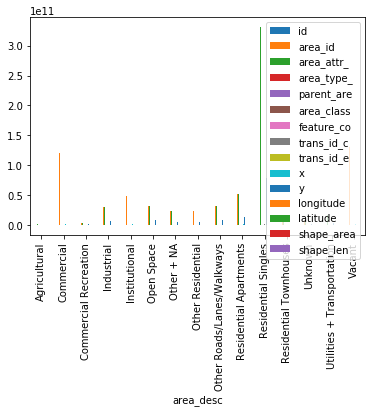

In [236]:
landzone.groupby(['area_desc']).count()
#buildings['m_ff_0'] = buildings.apply(lambda row: row.d_ff_0/(1.2*60), axis=1)
plt.clf()
landzone.groupby('area_desc').sum().plot(kind='bar')
plt.show()

In [439]:
landzone.groupby(['area_desc']).sum().transform(lambda x: x/np.sum(x)*100)

,id,area_id,area_attr_,area_type_,parent_are,area_class,feature_co,trans_id_c,trans_id_e,x,y,longitude,latitude,shape_area,shape_len
area_desc,,,,,,,,,,,,,,,
Agricultural,0.075239,0.077813,0.077813,0.077893,NaN,0.077893,NaN,0.077893,0.077893,0.081663,0.078122,0.077708,0.078121,NaN,NaN
Commercial,13.275920,13.926722,13.926722,13.923901,NaN,13.923901,NaN,13.923901,13.923901,13.903199,13.918318,13.924923,13.918342,NaN,NaN
Commercial Recreation,0.464857,0.432011,0.432011,0.431950,NaN,0.431950,NaN,0.431950,0.431950,0.425935,0.431818,0.432245,0.431819,NaN,NaN
Industrial,3.443527,3.569178,3.569178,3.568900,NaN,3.568900,NaN,3.568900,3.568900,3.548326,3.568388,3.569907,3.568391,NaN,NaN
Institutional,5.467518,5.572722,5.572722,5.572865,NaN,5.572865,NaN,5.572865,5.572865,5.564913,5.573109,5.573255,5.573110,NaN,NaN
Open Space,3.630471,3.606659,3.606659,3.606666,NaN,3.606666,NaN,3.606666,3.606666,3.616019,3.606653,3.606208,3.606652,NaN,NaN
Other + NA,2.656283,2.685353,2.685353,2.686116,NaN,2.686116,NaN,2.686116,2.686116,2.710933,2.687797,2.684899,2.687789,NaN,NaN
Other Residential,2.826371,2.758889,2.758889,2.759288,NaN,2.759288,NaN,2.759288,2.759288,2.778121,2.760225,2.758365,2.760220,NaN,NaN
Other Roads/Lanes/Walkways,3.595780,3.599768,3.599768,3.599585,NaN,3.599585,NaN,3.599585,3.599585,3.614870,3.599352,3.598836,3.599351,NaN,NaN


In [445]:
landzone['zones'] = landzone['area_desc']
landzone.drop(['x', 'y', 'longitude', 'latitude'  ], axis=1)

,id,geom,area_id,date_effec,date_expir,area_attr_,area_type_,parent_are,area_type,area_class,...,area_long_,area_name,area_desc,feature_co,feature__1,trans_id_c,trans_id_e,shape_area,shape_len,zones
0,1,"(POLYGON ((-79.58195881 43.64048003, -79.58067...",20300189,2008-08-20,3000-01-01,20300189,671,0,GLU,393,...,03,Residential Apartments,Residential Apartments,0,None,98165,-1,0.0,0.0,Residential Apartments
1,2,"(POLYGON ((-79.51130804 43.60030889, -79.51130...",20302538,2008-08-20,3000-01-01,20302538,671,0,GLU,393,...,11,Vacant,Vacant,0,None,98165,-1,0.0,0.0,Vacant
2,3,"(POLYGON ((-79.51747957000001 43.60068163, -79...",20302521,2008-08-20,3000-01-01,20302521,671,0,GLU,393,...,04,Commercial,Commercial,0,None,98165,-1,0.0,0.0,Commercial
3,4,"(POLYGON ((-79.51781195 43.60054139, -79.51745...",20302517,2008-08-20,3000-01-01,20302517,671,0,GLU,393,...,01,Residential Singles,Residential Singles,0,None,98165,-1,0.0,0.0,Residential Singles
4,5,"(POLYGON ((-79.50033784999999 43.60042557, -79...",20302514,2008-08-20,3000-01-01,20302514,671,0,GLU,393,...,03,Residential Apartments,Residential Apartments,0,None,98165,-1,0.0,0.0,Residential Apartments
5,6,"(POLYGON ((-79.42857725 43.63917765, -79.42859...",20300047,2008-08-20,3000-01-01,20300047,671,0,GLU,393,...,04,Commercial,Commercial,0,None,98165,-1,0.0,0.0,Commercial
6,7,"(POLYGON ((-79.43354161000001 43.63882685, -79...",20300043,2008-08-20,3000-01-01,20300043,671,0,GLU,393,...,01,Residential Singles,Residential Singles,0,None,98165,-1,0.0,0.0,Residential Singles
7,8,"(POLYGON ((-79.56303232 43.61945012, -79.56305...",20301663,2008-08-20,3000-01-01,20301663,671,0,GLU,393,...,04,Commercial,Commercial,0,None,98165,-1,0.0,0.0,Commercial
8,9,"(POLYGON ((-79.50680128 43.61974934, -79.50687...",20301660,2008-08-20,3000-01-01,20301660,671,0,GLU,393,...,13,Other Residential,Other Residential,0,None,98165,-1,0.0,0.0,Other Residential
9,10,"(POLYGON ((-79.57115817 43.63030814, -79.57120...",20301064,2008-08-20,3000-01-01,20301064,671,0,GLU,393,...,01,Residential Singles,Residential Singles,0,None,98165,-1,0.0,0.0,Residential Singles


In [446]:
# categorizing land use
landzone.zones.replace(['Residential Apartments','Residential Singles', 'Residential Townhouses', 'Other Residential'], ['residential', 'residential', 'residential', 'residential'], inplace=True)
landzone.zones.replace(['Commercial','Commercial Recreation'], ['business', 'business'], inplace=True)
#landzone.zones.replace(['Vacant'], ['unassigned'], inplace=True)
landzone.zones.replace(['Open Space'], ['open space'], inplace=True)
#landzone.zones.replace(['Agricultural'], ['agricultural'], inplace=True)
landzone.zones.replace(['Utilities + Transportation', 'Other Roads/Lanes/Walkways'], ['utilities', 'utilities'], inplace=True)
landzone.zones.replace(['Unknown', 'Other + NA', 'Agricultural', 'Vacant'], ['unassigned', 'unassigned', 'unassigned', 'unassigned'], inplace=True)

In [447]:
landzone.groupby(['zones']).sum().transform(lambda x: x/np.sum(x)*100)

,id,area_id,area_attr_,area_type_,parent_are,area_class,feature_co,trans_id_c,trans_id_e,x,y,longitude,latitude,shape_area,shape_len
zones,,,,,,,,,,,,,,,
Industrial,3.443527,3.569178,3.569178,3.568900,NaN,3.568900,NaN,3.568900,3.568900,3.548326,3.568388,3.569907,3.568391,NaN,NaN
Institutional,5.467518,5.572722,5.572722,5.572865,NaN,5.572865,NaN,5.572865,5.572865,5.564913,5.573109,5.573255,5.573110,NaN,NaN
business,13.740777,14.358733,14.358733,14.355851,NaN,14.355851,NaN,14.355851,14.355851,14.329135,14.350137,14.357168,14.350161,NaN,NaN
open space,3.630471,3.606659,3.606659,3.606666,NaN,3.606666,NaN,3.606666,3.606666,3.616019,3.606653,3.606208,3.606652,NaN,NaN
residential,50.564933,48.584226,48.584226,48.586130,NaN,48.586130,NaN,48.586130,48.586130,48.629519,48.589577,48.584002,48.589563,NaN,NaN
unassigned,17.736649,18.773147,18.773147,18.774489,NaN,18.774489,NaN,18.774489,18.774489,18.763498,18.777339,18.775023,18.777327,NaN,NaN
utilities,5.416124,5.535335,5.535335,5.535099,NaN,5.535099,NaN,5.535099,5.535099,5.548590,5.534797,5.534438,5.534796,NaN,NaN


In [453]:
landzone.crs = {'init' :'epsg:4326'}
landzone["geometry"] = landzone.geom
print(landzone.geometry)

0        (POLYGON ((-79.58195881 43.64048003, -79.58067...
1        (POLYGON ((-79.51130804 43.60030889, -79.51130...
2        (POLYGON ((-79.51747957000001 43.60068163, -79...
3        (POLYGON ((-79.51781195 43.60054139, -79.51745...
4        (POLYGON ((-79.50033784999999 43.60042557, -79...
5        (POLYGON ((-79.42857725 43.63917765, -79.42859...
6        (POLYGON ((-79.43354161000001 43.63882685, -79...
7        (POLYGON ((-79.56303232 43.61945012, -79.56305...
8        (POLYGON ((-79.50680128 43.61974934, -79.50687...
9        (POLYGON ((-79.57115817 43.63030814, -79.57120...
10       (POLYGON ((-79.41953506999999 43.65550148, -79...
11       (POLYGON ((-79.51640952 43.63351661, -79.51491...
12       (POLYGON ((-79.54668484 43.63424848, -79.54668...
13       (POLYGON ((-79.35483284 43.63172553, -79.35471...
14       (POLYGON ((-79.49454689 43.63213343, -79.49457...
15       (POLYGON ((-79.49955912999999 43.63381961, -79...
16       (POLYGON ((-79.57991088 43.63410923, -79.57994.

In [473]:
df.shape

(113060, 4)

In [474]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
geodf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geodf.shape

(113060, 4)

In [475]:
## Note the lack of NaNs; dropped anything that didn't intersect
intersect = gpd.sjoin(geodf, landzone, op='within', how='left')

In [477]:
intersect

,geom,longitude_left,latitude_left,geometry_left,index_right,id,area_id,date_effec,date_expir,area_attr_,...,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len,zones,geometry_right
0,(POINT (301272.5552999991 4826887.169199999)),-79.543679,43.583851,POINT (-79.543679 43.583851),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
1,(POINT (301151.2408999999 4827105.600899999)),-79.545182,43.585816,POINT (-79.545182 43.585816),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
2,(POINT (301175.3184000004 4827117.866599998)),-79.544884,43.585927,POINT (-79.544884 43.585927),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
3,(POINT (301242.5461999999 4827074.3986)),-79.544052,43.585536,POINT (-79.54405199999999 43.585536),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
4,(POINT (301215.1661000005 4827163.2271)),-79.544391,43.586335,POINT (-79.544391 43.586335),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
5,(POINT (301268.0613999997 4827217.052100001)),-79.543737,43.586820,POINT (-79.54373699999999 43.58682),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
6,(POINT (301310.0880999991 4827870.849600001)),-79.543220,43.592706,POINT (-79.54322000000001 43.592706),24355.0,24332.0,20302858.0,2008-08-20,3000-01-01,20302858.0,...,98165.0,-1.0,301264.837,4827849.652,-79.543589,43.592579,0.0,0.0,residential,"(POLYGON ((-79.54412634000001 43.59246512, -79..."
7,(POINT (301366.5815000007 4827838.101)),-79.542520,43.592411,POINT (-79.54252 43.592411),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,(POINT (301456.9724999987 4827710.5725)),-79.541400,43.591263,POINT (-79.5414 43.591263),4780.0,4716.0,20302889.0,2008-08-20,3000-01-01,20302889.0,...,98165.0,-1.0,301393.727,4827690.753,-79.541992,43.591149,0.0,0.0,residential,"(POLYGON ((-79.54250837000001 43.59067163, -79..."
9,(POINT (301253.1316000004 4827207.5396)),-79.543921,43.586734,POINT (-79.543921 43.586734),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."


In [478]:
intersect.groupby(['zones']).sum()


,longitude_left,latitude_left,index_right,id,area_id,area_attr_,area_type_,parent_are,area_class,feature_co,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len
zones,,,,,,,,,,,,,,,,,,
Industrial,-9.291368e+04,51126.953543,22366562.0,22324542.0,2.373160e+10,2.373160e+10,785070.0,0.0,459810.0,0.0,1.148530e+08,-1170.0,3.646984e+08,5.662289e+09,-9.291445e+04,51126.587015,0.0,0.0
Institutional,-2.057263e+05,113266.221365,58053497.0,57998518.0,5.254415e+10,5.254415e+10,1738561.0,0.0,1018263.0,0.0,2.543455e+08,-2591.0,8.104432e+08,1.254426e+10,-2.057269e+05,113265.929720,0.0,0.0
business,-3.362270e+05,184937.767292,89069348.0,89121292.0,8.589974e+10,8.589974e+10,2841014.0,0.0,1663962.0,0.0,4.156306e+08,-4234.0,1.320736e+09,2.048181e+10,-3.362274e+05,184937.062704,0.0,0.0
open space,-8.487326e+05,467313.486733,254709086.0,254835701.0,2.168439e+11,2.168439e+11,7174332.0,0.0,4201956.0,0.0,1.049580e+09,-10692.0,3.362103e+09,5.175513e+10,-8.487312e+05,467312.800031,0.0,0.0
residential,-1.578114e+06,868941.258505,455044530.0,454758819.0,4.031253e+11,4.031253e+11,13338138.0,0.0,7812054.0,0.0,1.951324e+09,-19878.0,6.233961e+09,9.623549e+10,-1.578123e+06,868939.145879,0.0,0.0
unassigned,-4.391353e+05,241847.973888,116813191.0,116657087.0,1.121839e+11,1.121839e+11,3711972.0,0.0,2174076.0,0.0,5.430488e+08,-5532.0,1.739078e+09,2.678480e+10,-4.391358e+05,241847.836018,0.0,0.0
utilities,-3.132862e+05,172549.688995,85023537.0,84894594.0,8.004275e+10,8.004275e+10,2648437.0,0.0,1551171.0,0.0,3.874573e+08,-3947.0,1.243226e+09,1.910996e+10,-3.132869e+05,172549.478375,0.0,0.0


In [479]:
intersect.head(2)

,geom,longitude_left,latitude_left,geometry_left,index_right,id,area_id,date_effec,date_expir,area_attr_,...,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len,zones,geometry_right
0,(POINT (301272.5552999991 4826887.169199999)),-79.543679,43.583851,POINT (-79.543679 43.583851),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
1,(POINT (301151.2408999999 4827105.600899999)),-79.545182,43.585816,POINT (-79.545182 43.585816),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."


In [480]:
intersect.groupby(['zones']).sum().transform(lambda x: x/np.sum(x)*100)

,longitude_left,latitude_left,index_right,id,area_id,area_attr_,area_type_,parent_are,area_class,feature_co,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len
zones,,,,,,,,,,,,,,,,,,
Industrial,2.436035,2.434636,2.068910,2.065958,2.435581,2.435581,2.435268,NaN,2.435268,NaN,2.435268,2.435268,2.419347,2.434621,2.436049,2.434624,NaN,NaN
Institutional,5.393787,5.393672,5.369955,5.367298,5.392621,5.392621,5.392973,NaN,5.392973,NaN,5.392973,5.392973,5.376343,5.393670,5.393789,5.393670,NaN,NaN
business,8.815287,8.806630,8.238925,8.247462,8.815914,8.815914,8.812755,NaN,8.812755,NaN,8.812755,8.812755,8.761539,8.806588,8.815275,8.806616,NaN,NaN
open space,22.252294,22.253200,23.560619,23.583003,22.254750,22.254750,22.254600,NaN,22.254600,NaN,22.254600,22.254600,22.303623,22.253215,22.252198,22.253215,NaN,NaN
residential,41.375411,41.378483,42.091671,42.084286,41.372863,41.372863,41.374573,NaN,41.374573,NaN,41.374573,41.374573,41.355043,41.378483,41.375525,41.378472,NaN,NaN
unassigned,11.513365,11.516661,10.805233,10.795679,11.513462,11.513462,11.514445,NaN,11.514445,NaN,11.514445,11.514445,11.536753,11.516691,11.513348,11.516680,NaN,NaN
utilities,8.213820,8.216717,7.864687,7.856315,8.214809,8.214809,8.215386,NaN,8.215386,NaN,8.215386,8.215386,8.247351,8.216732,8.213815,8.216725,NaN,NaN


In [481]:
intersect.shape

(113060, 31)

In [482]:
Toronto = pd.DataFrame(intersect, copy=True)
#Toronto['sample'] =  Toronto.groupby(['zones']).sum()/100*20000
#Toronto['sample'] =  Toronto['outofTwentyKsample'].astype(int)
Toronto

,geom,longitude_left,latitude_left,geometry_left,index_right,id,area_id,date_effec,date_expir,area_attr_,...,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len,zones,geometry_right
0,(POINT (301272.5552999991 4826887.169199999)),-79.543679,43.583851,POINT (-79.543679 43.583851),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
1,(POINT (301151.2408999999 4827105.600899999)),-79.545182,43.585816,POINT (-79.545182 43.585816),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
2,(POINT (301175.3184000004 4827117.866599998)),-79.544884,43.585927,POINT (-79.544884 43.585927),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
3,(POINT (301242.5461999999 4827074.3986)),-79.544052,43.585536,POINT (-79.54405199999999 43.585536),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
4,(POINT (301215.1661000005 4827163.2271)),-79.544391,43.586335,POINT (-79.544391 43.586335),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
5,(POINT (301268.0613999997 4827217.052100001)),-79.543737,43.586820,POINT (-79.54373699999999 43.58682),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."
6,(POINT (301310.0880999991 4827870.849600001)),-79.543220,43.592706,POINT (-79.54322000000001 43.592706),24355.0,24332.0,20302858.0,2008-08-20,3000-01-01,20302858.0,...,98165.0,-1.0,301264.837,4827849.652,-79.543589,43.592579,0.0,0.0,residential,"(POLYGON ((-79.54412634000001 43.59246512, -79..."
7,(POINT (301366.5815000007 4827838.101)),-79.542520,43.592411,POINT (-79.54252 43.592411),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,(POINT (301456.9724999987 4827710.5725)),-79.541400,43.591263,POINT (-79.5414 43.591263),4780.0,4716.0,20302889.0,2008-08-20,3000-01-01,20302889.0,...,98165.0,-1.0,301393.727,4827690.753,-79.541992,43.591149,0.0,0.0,residential,"(POLYGON ((-79.54250837000001 43.59067163, -79..."
9,(POINT (301253.1316000004 4827207.5396)),-79.543921,43.586734,POINT (-79.543921 43.586734),9909.0,9867.0,20302929.0,2008-08-20,3000-01-01,20302929.0,...,98165.0,-1.0,301240.444,4827085.117,-79.543887,43.585697,0.0,0.0,open space,"(POLYGON ((-79.54008828000001 43.58592217, -79..."


In [483]:
grouped = Toronto.groupby('zones')
grouped.apply(lambda x: x.sample(frac=0.2))

geom  \
zones                                                              
Industrial 32899         (POINT (319700.7185 4841147.499999999))   
           14366   (POINT (310196.4245000002 4836451.460499999))   
           749     (POINT (302338.0311000007 4831978.726899999))   
           37332   (POINT (316584.6101000005 4846582.635500002))   
           58958   (POINT (316728.1965999996 4834335.132599999))   
           50450   (POINT (324631.1972000008 4852229.853599999))   
           99792                  POINT (295556.874 4844542.384)   
           3398    (POINT (298933.7089999996 4839974.776000001))   
           60174                  POINT (301877.426 4832763.097)   
           67556                  POINT (306966.973 4837095.886)   
           86187                  POINT (317000.373 4833223.549)   
           45255   (POINT (322165.5083999995 4844908.206900001))   
           24290         (POINT (307462.3793999997 4846329.023))   
           99069                  POINT (322946.479 4840141.156)   
           104507                 POINT (322838.171 4840605.457)   
           21640    (POINT (296074.455299999 4845574.863899999))   
           5207         (POINT (305314.9255999995 4831489.4427))   
           39422        (POINT (323052.0805999988 4839974.7346))   
           39450        (POINT (323000.6368000002 4840140.3121))   
           14206    (POINT (309886.832499998 4836424.415999999))   
           12221   (POINT (307480.7993000002 4841031.915899999))   
           51471   (POINT (317503.4270999999 4833220.574899999))   
           70484                  POINT (305605.519 4839187.053)   
           44940           (POINT (321729.7189999988 4846364.5))   
           42594   (POINT (325454.0998000001 4848545.910399999))   
           24284        (POINT (306319.3424000003 4846188.8079))   
           57733   (POINT (323001.4767000003 4840220.562999999))   
           11189        (POINT (307154.8925000005 4837695.0534))   
           1029         (POINT (302049.3739000001 4832779.8518))   
           27183        (POINT (308821.6800000001 4846736.6285))   
...                                                          ...   
utilities  106952                 POINT (318267.808 4847571.896)   
           79970                  POINT (316035.396 4849931.537)   
           76626                      POINT (314071.5 4838008.5)   
           86640                  POINT (316664.782 4834670.026)   
           43454   (POINT (322094.5884999994 4849292.030499999))   
           60062                  POINT (301559.728 4832340.458)   
           46302   (POINT (323082.4395000002 4845174.730500001))   
           91017                  POINT (319769.059 4852138.244)   
           110094                 POINT (315540.254 4848854.019)   
           23644        (POINT (305462.1941999999 4844832.2975))   
           111670                     POINT (316886 4841055.051)   
           97173                  POINT (332914.422 4846673.864)   
           46076   (POINT (322402.0044999995 4844110.481499999))   
           94475                  POINT (327509.857 4853164.166)   
           79839                    POINT (299208.56 4846141.55)   
           33132   (POINT (319619.4719999987 4835651.561000001))   
           42734        (POINT (311758.1585000001 4833299.5305))   
           81714                  POINT (308394.645 4842891.788)   
           102891                 POINT (321948.204 4847329.069)   
           63785                  POINT (303932.386 4827597.403)   
           3707    (POINT (299872.2209000001 4841736.162299999))   
           72272                  POINT (310957.928 4833211.158)   
           72903                  POINT (311509.561 4833677.883)   
           56031        (POINT (313883.1489000007 4838233.9951))   
           53067   (POINT (313827.5314999993 4838033.398499999))   
           92175                  POINT (313615.368 4849213.288)   
           102680                 POINT (321527.

In [484]:
grouped.count()

,geom,longitude_left,latitude_left,geometry_left,index_right,id,area_id,date_effec,date_expir,area_attr_,...,feature__1,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len,geometry_right
zones,,,,,,,,,,,,,,,,,,,,,
Industrial,1170,1170,1170,1170,1170,1170,1170,1170,1170,1170,...,0,1170,1170,1170,1170,1170,1170,1170,1170,1170
Institutional,2591,2591,2591,2591,2591,2591,2591,2591,2591,2591,...,0,2591,2591,2591,2591,2591,2591,2591,2591,2591
business,4234,4234,4234,4234,4234,4234,4234,4234,4234,4234,...,0,4234,4234,4234,4234,4234,4234,4234,4234,4234
open space,10692,10692,10692,10692,10692,10692,10692,10692,10692,10692,...,0,10692,10692,10692,10692,10692,10692,10692,10692,10692
residential,19878,19878,19878,19878,19878,19878,19878,19878,19878,19878,...,0,19878,19878,19878,19878,19878,19878,19878,19878,19878
unassigned,5532,5532,5532,5532,5532,5532,5532,5532,5532,5532,...,0,5532,5532,5532,5532,5532,5532,5532,5532,5532
utilities,3947,3947,3947,3947,3947,3947,3947,3947,3947,3947,...,0,3947,3947,3947,3947,3947,3947,3947,3947,3947


In [485]:
Toronto.shape

(113060, 31)

In [489]:
# generating 20% sample 
rows = Toronto.sample(frac =.20) 
  
# checking if sample is 0.25 times data or not 
  
if (0.25*(len(Toronto))== len(rows)): 
    print( "Cool") 
    print(len(Toronto), len(rows)) 
  
# display 
rows 

,geom,longitude_left,latitude_left,geometry_left,index_right,id,area_id,date_effec,date_expir,area_attr_,...,trans_id_c,trans_id_e,x,y,longitude_right,latitude_right,shape_area,shape_len,zones,geometry_right
47373,(POINT (335040.6399999998 4849552.6361)),-79.124277,43.787262,POINT (-79.12427700000001 43.787262),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13756,(POINT (311056.7595 4834682.636499998)),-79.422435,43.654004,POINT (-79.42243499999999 43.654004),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60794,POINT (302425.951 4835103.154),-79.529236,43.657865,POINT (-79.52923554900001 43.657865317),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43617,(POINT (325559.4460999999 4843156.964500001)),-79.242321,43.730020,POINT (-79.242321 43.73002),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109208,POINT (316020.639 4845467.737),-79.360475,43.751081,POINT (-79.360474638 43.751080679),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73995,POINT (309891.647 4836494.205),-79.436664,43.670375,POINT (-79.436663784 43.670374701),27098.0,27069.0,20289851.0,2008-08-20,3000-01-01,20289851.0,...,98165.0,-1.0,309917.426,4836491.656,-79.436347,43.670360,0.0,0.0,utilities,"(POLYGON ((-79.43689247 43.67049854, -79.43666..."
105778,POINT (324592.978 4854242.4),-79.253708,43.829884,POINT (-79.253707889 43.829884122),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17296,(POINT (312621.0954999996 4835551.1423)),-79.403030,43.661807,POINT (-79.40303 43.661807),1628.0,1610.0,20293096.0,2008-08-20,3000-01-01,20293096.0,...,98165.0,-1.0,312601.992,4835558.260,-79.403070,43.661935,0.0,0.0,residential,"(POLYGON ((-79.40271659 43.66190718, -79.40294..."
13246,(POINT (311189.6849999995 4833548.913000002)),-79.420801,43.643797,POINT (-79.420801 43.643797),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46630,(POINT (326848.996 4852478.885999999)),-79.225932,43.813891,POINT (-79.225932 43.813891),8202.0,8139.0,20261447.0,2008-08-20,3000-01-01,20261447.0,...,98165.0,-1.0,326957.656,4852418.736,-79.224384,43.813411,0.0,0.0,Institutional,"(POLYGON ((-79.22230762 43.81366436, -79.22282..."


In [491]:
rows.shape

(22612, 31)

In [493]:
# percentage of zon types
rows.zones.value_counts()/rows.zones.count()*100

residential      40.979863
open space       22.462113
unassigned       11.739672
business          8.667220
utilities         8.521902
Institutional     5.397550
Industrial        2.231679
Name: zones, dtype: float64

In [494]:
rows.shape

(22612, 31)

In [499]:
sample20000 = (rows.zones.value_counts()/rows.zones.count()*100/100*22612).astype(int)
sample20000

residential      9266
open space       5079
unassigned       2654
business         1959
utilities        1926
Institutional    1220
Industrial        504
Name: zones, dtype: int64